# Loading tf events file

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tensorflow.tensorboard.backend.event_processing import event_accumulator
from collections import defaultdict
import numpy as np
import graphviz

In [2]:
path = 'archive-2017-07-10/named_results/model.shortcutsL1.1e-06_shortcutsL1_final.0.01_shortcutsL1_steps.30000.0_'
collection_name = 'scalars'

In [3]:
ea = event_accumulator.EventAccumulator(path, #'example_results/events.out.tfevents.1496749144.L-E7-thalita'
                                        size_guidance={ # see below regarding this argument
                                        event_accumulator.COMPRESSED_HISTOGRAMS: 500,
                                        event_accumulator.IMAGES: 4,
                                        event_accumulator.AUDIO: 4,
                                        event_accumulator.SCALARS: 0,
                                        event_accumulator.HISTOGRAMS: 1,
                                         })
ea.Reload() # loads events from file
print(ea.Tags().keys())

INFO:tensorflow:No path found after archive-2017-07-10/named_results/model.shortcutsL1.1e-06_shortcutsL1_final.0.01_shortcutsL1_steps.30000.0_/events.out.tfevents.1499441608.sirocco03
dict_keys(['run_metadata', 'graph', 'histograms', 'images', 'tensors', 'compressedHistograms', 'scalars', 'audio', 'meta_graph'])


In [4]:
collection = ea.Scalars
event = collection('vgg_16/combfc7/w_l5_vgg_16/conv3/conv3_1/Relu_')
event

[ScalarEvent(wall_time=1499441625.6028006, step=1, value=6.666666649834951e-07),
 ScalarEvent(wall_time=1499442043.7609868, step=501, value=-0.013554058969020844),
 ScalarEvent(wall_time=1499442367.383118, step=1001, value=0.005841722246259451),
 ScalarEvent(wall_time=1499442691.3896527, step=1501, value=0.002778158988803625),
 ScalarEvent(wall_time=1499443014.9903975, step=2001, value=-0.007007869891822338),
 ScalarEvent(wall_time=1499443338.483912, step=2501, value=0.006433299742639065),
 ScalarEvent(wall_time=1499443756.308538, step=3001, value=-0.014130093157291412),
 ScalarEvent(wall_time=1499444079.9400485, step=3501, value=0.009513357654213905),
 ScalarEvent(wall_time=1499444403.2671747, step=4001, value=0.007808297872543335),
 ScalarEvent(wall_time=1499444726.831247, step=4501, value=-0.014818409457802773),
 ScalarEvent(wall_time=1499445050.5692377, step=5001, value=0.004110747016966343),
 ScalarEvent(wall_time=1499445469.2055256, step=5501, value=-0.00019593910838011652),
 Sca

In [5]:
name_func = 'comb'
values = defaultdict(list)
for function in ea.Tags()[collection_name]:
    if function.find(name_func) > -1: #to find an approximate name_func 
        for element in (collection(function)):
            values[function].append(element.value)

# Graphviz to see shortcuts

* Orange marks negative shortcut weights
* Blue is for positive shortcut weights
* Black marks direct connections

In [17]:
from graphviz import Digraph
import networkx as nx

def add_edge(src, dst, weight=1.0, color='black'):
    G.edge(src, dst, label="%0.3f" % weight, color=color)
    nxG.add_edge(src, dst, weight=weight)

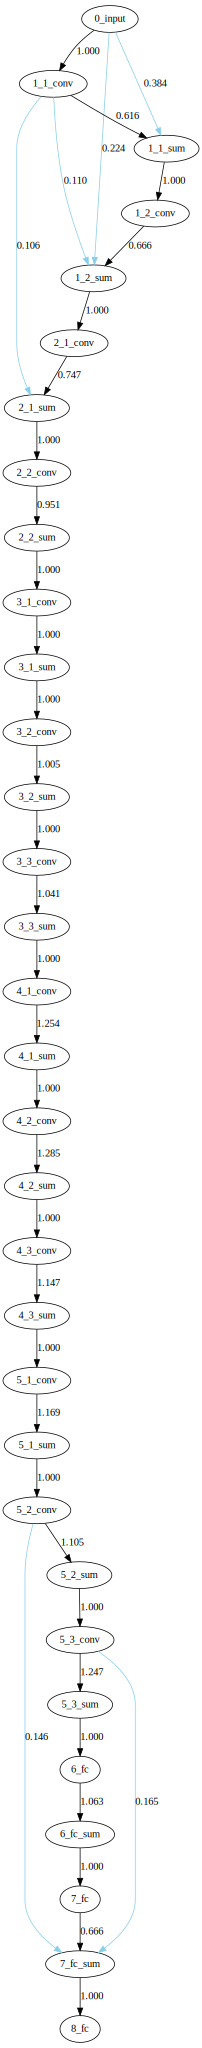

In [30]:
G = Digraph('net')
nxG = nx.DiGraph()

#vgg 16 pattern
rep = [2, 2, 3, 3, 3]
# min weight to be drawn
min_weight = 1e-1

add_edge('0_input', '1_1_conv')
# adding fixed sum -> next layer connection
layers = []
combs = []
for l in range(5):
    for l_i in range(rep[l]):
        pref = '%d_%d' % (l + 1, l_i + 1)
        layers.append(pref + '_conv')
        combs.append(pref + '_sum')
fc_layers = ['6_fc', '7_fc', '8_fc']
layers += fc_layers
for i in range(len(fc_layers) - 1):
    combs.append(fc_layers[i] + '_sum')
    
for i in range(len(layers)-1):
    add_edge(combs[i], layers[i + 1])
    
# now adding shortcut connections
weight_sum = defaultdict(int)
for name, curve in values.items():
    weight = curve[-1]
    parts = name.split('/')
    to = parts[1].strip('comb') + '_sum'
    if to.find('fc') > -1:
        to = parts[1].strip('comb').strip('fc') + '_fc_sum'
    weight_sum[to] += weight
    if parts[3].find('conv') > -1:
        orig =  parts[4].strip('conv') + '_conv'
    elif parts[3].find('batch') > -1:
        orig = '0_input'
    else:
        orig = parts[3].strip('fc') + '_fc'

    if abs(weight) > min_weight:
        color = 'skyblue' if weight >0 else 'coral'
        add_edge(orig, to, weight=weight, color=color)
        
# compute direct weights = 1 - sum_shortcuts
prev_layer = dict(zip(combs, layers))
for name, val in weight_sum.items():
    add_edge(prev_layer[name], name, weight=1-val)

G

In [31]:
weight_sum

defaultdict(int,
            {'1_1_sum': 0.3842284381389618,
             '1_2_sum': 0.3344355747103691,
             '2_1_sum': 0.2526753470301628,
             '2_2_sum': 0.04904903605347499,
             '3_1_sum': -0.0004674453957704827,
             '3_2_sum': -0.00516196851094719,
             '3_3_sum': -0.04144133965019137,
             '4_1_sum': -0.25397712364792824,
             '4_2_sum': -0.28467803285457194,
             '4_3_sum': -0.1469144347938709,
             '5_1_sum': -0.1690284484066069,
             '5_2_sum': -0.10461338553432142,
             '5_3_sum': -0.2469807125016814,
             '6_fc_sum': -0.06269655165669974,
             '7_fc_sum': 0.3343010535463691})

In [32]:
nxG.adj

{'0_input': {'1_1_conv': {'weight': 1.0},
  '1_1_sum': {'weight': 0.3842284381389618},
  '1_2_sum': {'weight': 0.22443002462387085}},
 '1_1_conv': {'1_1_sum': {'weight': 0.6157715618610382},
  '1_2_sum': {'weight': 0.11000555008649826},
  '2_1_sum': {'weight': 0.10568113625049591}},
 '1_1_sum': {'1_2_conv': {'weight': 1.0}},
 '1_2_conv': {'1_2_sum': {'weight': 0.6655644252896309}},
 '1_2_sum': {'2_1_conv': {'weight': 1.0}},
 '2_1_conv': {'2_1_sum': {'weight': 0.7473246529698372}},
 '2_1_sum': {'2_2_conv': {'weight': 1.0}},
 '2_2_conv': {'2_2_sum': {'weight': 0.950950963946525}},
 '2_2_sum': {'3_1_conv': {'weight': 1.0}},
 '3_1_conv': {'3_1_sum': {'weight': 1.0004674453957705}},
 '3_1_sum': {'3_2_conv': {'weight': 1.0}},
 '3_2_conv': {'3_2_sum': {'weight': 1.0051619685109472}},
 '3_2_sum': {'3_3_conv': {'weight': 1.0}},
 '3_3_conv': {'3_3_sum': {'weight': 1.0414413396501914}},
 '3_3_sum': {'4_1_conv': {'weight': 1.0}},
 '4_1_conv': {'4_1_sum': {'weight': 1.2539771236479282}},
 '4_1_sum'